In [7]:
import helper
import plotting
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import scanpy as sc

import warnings
warnings.filterwarnings("ignore")

In [8]:
# Set the path to the data directory and model directory
PATH = ["F:/cellpose/full_set"]
MOD_DIR= "F:/cellpose/full_set/train/models"

In [9]:
# Run the prediction	
res = helper.prediction.batch_predict(MOD_DIR,PATH,mute=True,return_results=True,save_masks=False,min_size=-1)

full_set found...


F:/cellpose/full_set/train/: 100%|██████████| 67/67 [06:35<00:00,  5.90s/image]


In [12]:
# Get style vectors and names
all_styles = res['full_set_0']['styles']
all_names = res['full_set_0']['id']

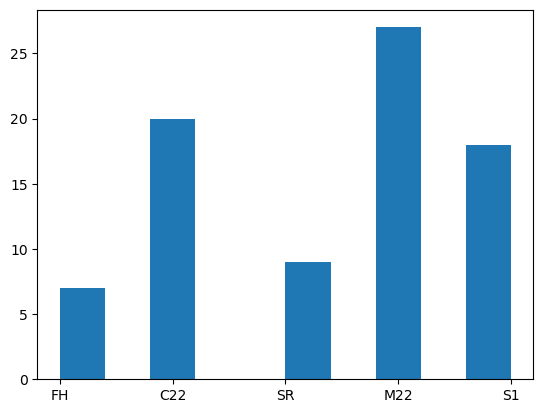

In [435]:
classes = ['C22','M22','FH','SR','S1']
C22_keys = ['kanaka','DS8','deer','hidden']
M22_keys = ['L2','K1','S9']
S1_keys = ['S1']
FH_keys = ['P106']
SR_keys = ['GU','Luet','Rhein','Simme','Thur']
data_classes = []
for idx in range(len(all_names)):
    if any (x in all_names[idx] for x in C22_keys):
        cl_name='C22'
    elif any (x in all_names[idx] for x in M22_keys):
        cl_name='M22'
    elif any (x in all_names[idx] for x in S1_keys):
        cl_name='S1'
    elif any (x in all_names[idx] for x in FH_keys):
        cl_name='FH'
    elif any (x in all_names[idx] for x in SR_keys):
        cl_name='SR'
    else:
        cl_name='unknown'
    data_classes.append(cl_name)
plt.hist(data_classes);


In [323]:
aData = pd.DataFrame(all_styles)
aData.shape

(81, 256)

In [449]:
from scipy.sparse import csc_matrix
sparseMatrix = csc_matrix(all_styles, 
                          dtype = np.float32).toarray()
print(sparseMatrix.shape)
adata=sc.AnnData(sparseMatrix)
adata.obs_names= all_names
adata.obs["class"]=data_classes
print(adata)
print(adata.obs_names[:10])

(81, 256)
AnnData object with n_obs × n_vars = 81 × 256
    obs: 'class'
Index(['4_P1060348_3', 'DS8-S2_3', 'GU_bar7_0', 'K1_2_C1_DJI_0385_clipped_4',
       'L2_1_C1_DJI_0371_3', 'S1_a_DJI_0003_2_0', 'S1_g_DJI_0171_2_0',
       'S1_g_DJI_0171_2_3', 'S1_g_DJI_0208_2_6', 'S9_5_C1_DJI_0102_2'],
      dtype='object')


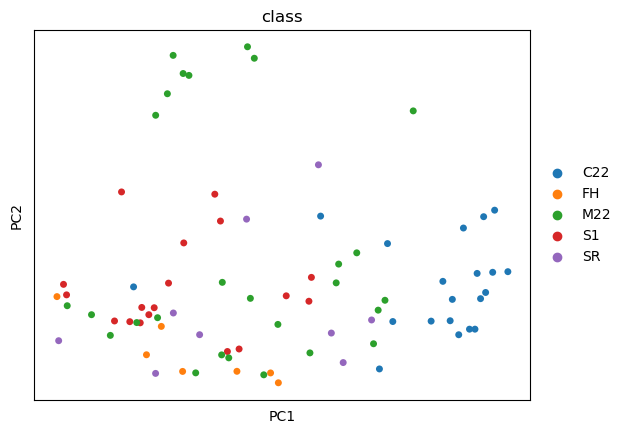

In [451]:
sc.tl.pca(adata)
sc.pl.pca(adata,color='class',size=100)

[0.32434473 0.22665152]


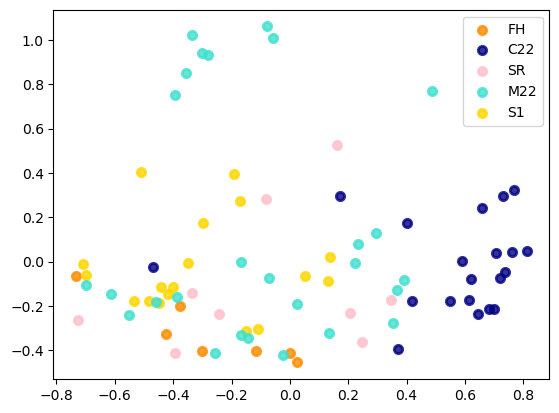

In [448]:
#sanity check with sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(all_styles)
print(pca.explained_variance_ratio_)
X=pca.transform(all_styles)

colors = ["navy", "turquoise", "darkorange","pink","gold"]
target_names = ['C22','M22','FH','SR','S1']

lw = 2
for point in range(len(X)):
    if data_classes[point]=='C22':
        c=colors[0]
    elif data_classes[point]=='M22':
        c=colors[1]
    elif data_classes[point]=='FH':
        c=colors[2]
    elif data_classes[point]=='SR':
        c=colors[3]
    elif data_classes[point]=='S1':
        c=colors[4]
    else:
        c='black'
    plt.scatter(X[point, 0], X[point, 1],color=c, alpha=.8, lw=lw,label=data_classes[point])

from collections import OrderedDict

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

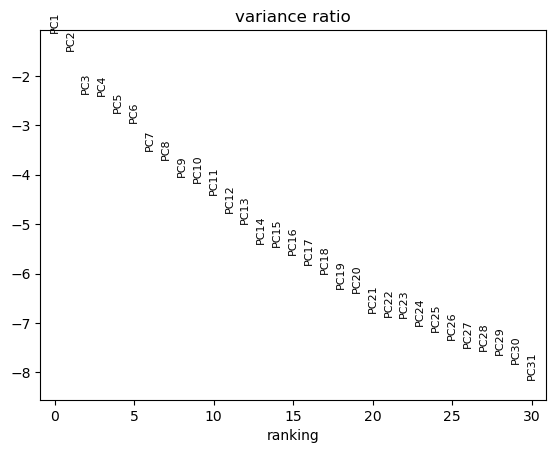

In [452]:
sc.pl.pca_variance_ratio(adata, log=True,)

In [455]:
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=40)

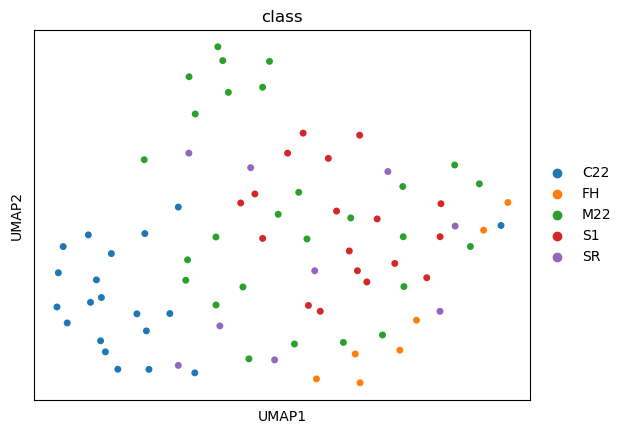

In [457]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='class', use_raw=False,size=100)

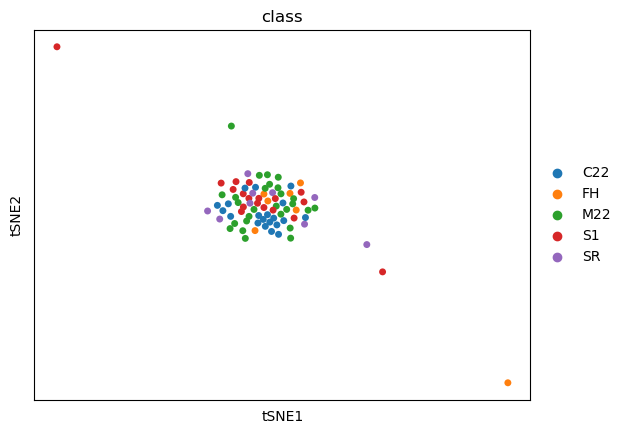

AnnData object with n_obs × n_vars = 81 × 256
    obs: 'class'
    uns: 'pca', 'class_colors', 'neighbors', 'umap', 'tsne'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [458]:
sc.tl.tsne(adata)
sc.pl.tsne(adata,color='class',size=100)
print(adata)

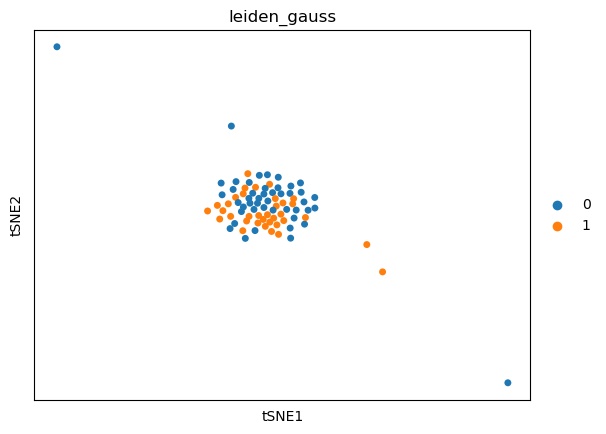

0    46
1    35
Name: leiden_gauss, dtype: int64


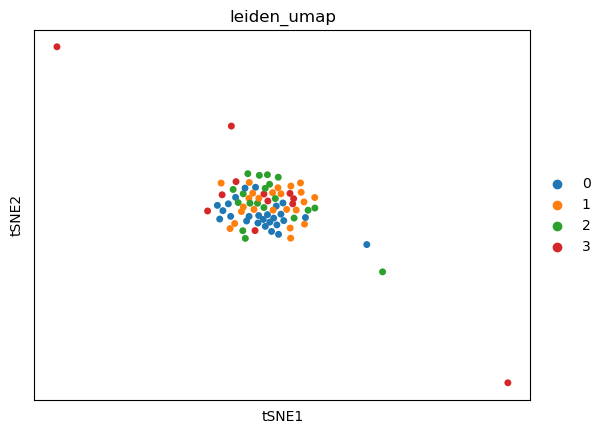

0    26
1    24
2    19
3    12
Name: leiden_umap, dtype: int64


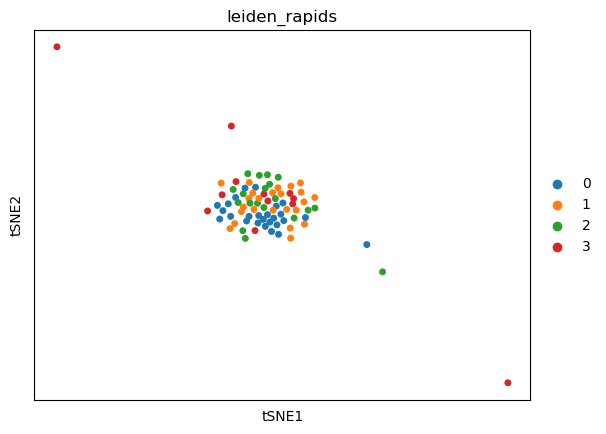

0    26
1    24
2    19
3    12
Name: leiden_rapids, dtype: int64


In [400]:
method_l = ['gauss','umap','rapids']
for k in range(3):
    #neighborhood graph https://scanpy.readthedocs.io/en/latest/generated/scanpy.pp.neighbors.html#scanpy-pp-neighbors
    sc.pp.neighbors(adata, n_neighbors=41, n_pcs=40,method=method_l[k],key_added=str(method_l[k])+'_neighbors')
    #clustering using the leiden algorithm https://scanpy.readthedocs.io/en/latest/generated/scanpy.tl.leiden.html#scanpy-tl-leiden
    sc.tl.leiden(adata, resolution=0.8, neighbors_key=str(method_l[k])+'_neighbors',key_added='leiden_'+str(method_l[k]))
    #plotting the clusters
    sc.pl.tsne(adata, color=['leiden_'+str(method_l[k])],size=100)
    print(adata.obs['leiden_'+str(method_l[k])].value_counts())